# Covid -19 rates in Incarceration facilities 

## Imports
---

In [1023]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import datetime
import time
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

## Problem Statement
---
The goal of this project is to examine trends in the rates that inmates and staff members in different state prisons were affected by COVID-19 and draw insights into what could be causing those trends. 


## Background 
---
Mass incarceration in the United States began in the 1970's and since then the number of inmates in prison has increased nearly 1000 percent and is currently over 1.8million people! 
https://www.vox.com/2015/7/13/8913297/mass-incarceration-maps-charts

The Covid-19 pandemic hit the United States the hardest in 2020. In the time since the pandemic began there have been nearly 34 million cases of covid-19 in the United States. Among those cases, there have been over 600,000 deaths in the general Us Population due to Covid-19.

Just like the pandemic hit free Americans, it also hit prisoners. As it stands there have been nearly 400,000 cases of covid-19 among prisoners and among those cases there have been over 2700 deaths. 

https://www.themarshallproject.org/2020/05/01/a-state-by-state-look-at-coronavirus-in-prisons

## Data
---
The data for this analysis was gathered by the Marshall Project and retrieved from their public github profile. The data was collected from March 2020 up until July 2021 and is a comprehensive tracker of all covid-19 tests administered in all state and federal prisons within the United States. The methodologies and more in depth description of the data can be found here: https://github.com/themarshallproject/COVID_prison_data.

This analysis will use four datasets, here is a general description of each:

The dataset "cases" is a time series collection of commulatiive covid-19 tests and deaths among staff and prisoners in incarceration facilities. The data for this set was collected weekly.

The dataset "rates" ia a single snapshot dataset of data pertaining to the final rates of COVID-19 contraction and deaths among staff and prisoners in incarceration facilities. The data listed in this set are as of June 2021, the final day of data gathering for this dataset.

The dataset "inmate_pops" is a collection of prisoner populations collected monthly from March 2020 - June 2021

The dataset "staff_pops" is a collection of prisoner populations collected monthly from March 2020 - June 2021

All of these datasets will be combined to create a dataset title "model_rates" which is the dataset that will be used for modeling


In [1024]:
cases = pd.read_csv("./COVID_prison_data/data/covid_prison_cases.csv")
rates = pd.read_csv("./COVID_prison_data/data/covid_prison_rates.csv")
inmate_pops = pd.read_csv("./COVID_prison_data/data/prison_populations.csv")
staff_pops = pd.read_csv("./COVID_prison_data/data/staff_populations.csv")

# Data Cleaning and EDA
---

---
### Cases Dataset
---

In [1025]:
cases.head()

,name,abbreviation,staff_tests,staff_tests_with_multiples,total_staff_cases,staff_recovered,total_staff_deaths,staff_partial_dose,staff_full_dose,prisoner_tests,prisoner_tests_with_multiples,total_prisoner_cases,prisoners_recovered,total_prisoner_deaths,prisoners_partial_dose,prisoners_full_dose,as_of_date,notes
0,Alabama,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alaska,AK,NaN,NaN,332.0,NaN,0.0,NaN,NaN,NaN,38707.0,2440.0,NaN,5.0,3460.0,3097.0,06/22/2021,vaccines as of June 23
2,Arizona,AZ,NaN,NaN,2787.0,2778.0,NaN,NaN,NaN,47899.0,NaN,12328.0,12251.0,65.0,NaN,NaN,06/22/2021,NaN
3,Arkansas,AR,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,11425.0,11353.0,52.0,NaN,NaN,06/23/2021,We have been told vaccinations have begun in t...
4,California,CA,NaN,NaN,NaN,NaN,NaN,35295.0,33474.0,129415.0,1602906.0,49395.0,48517.0,227.0,71317.0,69400.0,06/22/2021,NaN


In [1026]:
#Narrowing down to columns necesarry for the purposes of this analysis 
model_cases = cases[['name','abbreviation','total_staff_cases','total_staff_deaths','total_prisoner_cases',
                     'total_prisoner_deaths','as_of_date']].set_index('name') 

In [1027]:
model_cases.head()

,abbreviation,total_staff_cases,total_staff_deaths,total_prisoner_cases,total_prisoner_deaths,as_of_date
name,,,,,,
Alabama,AL,NaN,NaN,NaN,NaN,NaN
Alaska,AK,332.0,0.0,2440.0,5.0,06/22/2021
Arizona,AZ,2787.0,NaN,12328.0,65.0,06/22/2021
Arkansas,AR,NaN,4.0,11425.0,52.0,06/23/2021
California,CA,NaN,NaN,49395.0,227.0,06/22/2021


In [1028]:
# Formatting the date for analysis
model_cases['as_of_date'] = pd.to_datetime(model_cases['as_of_date'])

The dataset "cases" was narrowed down to only contain columns containg data on the total number of cases and deaths from COVID-19 among prisoners and staff. Testing data was left out because it will not be analyzed in this study. The narrowed dataset was renamed "model_cases" and the "as_of_date" column was transformed to a format that will allow it to analyzed using later in the project. 

In [1029]:
#Checking to see how many intervals of data each state has 
model_cases['abbreviation'].value_counts().head()

LA    66
ME    66
HI    66
WY    66
GA    66
Name: abbreviation, dtype: int64

In [1030]:
#Creating lists of each region and the states contained within each region

North_East =['ME','VT','NH','MA','CT','NY','PA','NJ','RI']
South =['TX','OK','AR','LA','MS','TN','AL','GA','FL','SC','KY','VA','NC','WV','DE','MD']
Midwest = ['ND','SD','NE','KS','MO','IA','IL','IN','OH','MI','WI','MN','OH']
West = ['WA','OR','CA','MT','ID','NV','AZ','NM','CO','UT','WY','HI','AK']
Federal = ['US']

#Creating a dictionairy that will have the states as well as a number specifying their region
region_dict = {}

regions = [North_East, South, Midwest, West,Federal]

region_dict = {}
for index, region in enumerate(regions):
    dict_to_add = {state: index+1 for state in region}
    region_dict.update(dict_to_add) 


In [1031]:
#Checking to make sure all states are accounted for and have assigned region specifiers
set(model_cases['abbreviation'].unique()) - set(region_dict.keys())

set()

In [1032]:
#Creating a column assigning values to each state corresponding to their geographical region in the US. 
model_cases['region'] = model_cases['abbreviation'].map(region_dict)

A new column titled 'region' was created. This column assigned every state a number which corresponds to its region in the country.North East = 1, South = 2, Midwest = 3, West = 4 and Federal which refers to federal prisons = 5.

In [1033]:
model_cases.head()

,abbreviation,total_staff_cases,total_staff_deaths,total_prisoner_cases,total_prisoner_deaths,as_of_date,region
name,,,,,,,
Alabama,AL,NaN,NaN,NaN,NaN,NaT,2
Alaska,AK,332.0,0.0,2440.0,5.0,2021-06-22,4
Arizona,AZ,2787.0,NaN,12328.0,65.0,2021-06-22,4
Arkansas,AR,NaN,4.0,11425.0,52.0,2021-06-23,2
California,CA,NaN,NaN,49395.0,227.0,2021-06-22,4


In [1034]:
model_cases.shape

(3366, 7)

In [1035]:
#Checking for null values 
model_cases.isnull().sum()

abbreviation               0
total_staff_cases        292
total_staff_deaths       515
total_prisoner_cases     143
total_prisoner_deaths    135
as_of_date                24
region                     0
dtype: int64

In [1161]:
# Creating datasets for each of the regions. Two different methods 

NE_data = model_cases.loc[model_cases['region'] == 1]

South_data = model_cases.loc[model_cases['region'] == 2]

MW_data = model_cases.loc[model_cases['region'] == 3]

West_data = model_cases.loc[model_cases['abbreviation'].isin(West)]

Fed_data = model_cases.loc[model_cases['abbreviation'].isin(Federal)]

In [1164]:
#Preliminary Initial means for total prisoner cases by region ignoring total population
print("North East Mean total prisoner cases:", NE_data['total_prisoner_cases'].mean())
print("South Mean total prisoner cases:", South_data['total_prisoner_cases'].mean())
print("Midwest Mean total prisoner cases:", MW_data['total_prisoner_cases'].mean())
print("West Mean total prisoner cases:", West_data['total_prisoner_cases'].mean())
print("Federal Mean total prisoner cases:", Fed_data['total_prisoner_cases'].mean())

North East Mean total prisoner cases: 1638.4150268336314
South Mean total prisoner cases: 4798.75944333996
Midwest Mean total prisoner cases: 3867.374352331606
West Mean total prisoner cases: 3834.25
Federal Mean total prisoner cases: 19030.58


In [1163]:
#Preliminary Initial means for total staff cases by region ignoring total population
South_data['total_prisoner_cases'].describe()
print("North East Mean total staff cases:", NE_data['total_staff_cases'].mean())
print("South Mean total staff cases:", South_data['total_staff_cases'].mean())
print("Midwest Mean total staff cases:", MW_data['total_staff_cases'].mean())
print("West Mean total staff cases:", West_data['total_staff_cases'].mean())
print("Federal Mean total staff cases:", Fed_data['total_staff_cases'].mean())

North East Mean total staff cases: 801.3418181818182
South Mean total staff cases: 1300.345532831001
Midwest Mean total staff cases: 1070.7786998616873
West Mean total staff cases: 949.2071960297767
Federal Mean total staff cases: 3446.939393939394


The regional data was broken down into new datasets for each region and the mean for both the inmate cases and the staff cases were calculatued. Based on this initial analysis, which does not take into account the total population we can infer that on average federal prisons had the highest number of covid-19 cases among both inmates and staff. 

---
### Rates Dataset
---

In [1037]:
#Checking the dataset layout
rates.head()

,name,latest_week,cumulative_prisoner_cases,prisoner_cases_pct,prisoner_case_rate,cumulative_prisoner_deaths,prisoner_deaths_pct,prisoner_death_rate,cumulative_staff_cases,staff_cases_pct,staff_case_rate,cumulative_staff_deaths,staff_deaths_pct,staff_death_rate
0,Alabama,06/22/2021,1661,0.078668,1 in 13 prisoners,66,0.003126,1 in 320 prisoners,1056,0.278481,1 in 4 staff,3,0.000791,1 in 1264 staff
1,Alaska,06/22/2021,2440,0.510888,1 in 2 prisoners,5,0.001047,1 in 955 prisoners,332,0.224173,1 in 4 staff,0,0.000000,0
2,Arizona,06/22/2021,12328,0.291029,2 in 7 prisoners,65,0.001534,1 in 652 prisoners,2787,0.306432,1 in 3 staff,1,0.000110,1 in 9095 staff
3,Arkansas,06/22/2021,11425,0.652783,2 in 3 prisoners,52,0.002971,1 in 337 prisoners,813,0.148901,1 in 7 staff,4,0.000733,1 in 1365 staff
4,California,06/22/2021,49395,0.419886,2 in 5 prisoners,227,0.001930,1 in 518 prisoners,17002,0.267870,1 in 4 staff,28,0.000441,1 in 2267 staff


In [1038]:
#The number of rows and columns
rates.shape

(52, 14)

In [1039]:
#creating a dataset to merge the 'abbreviation' and 'region' columns for analysis
a = cases['abbreviation'].unique()
b = cases['name'].unique()
c = model_cases['region']
for_merge = pd.DataFrame(np.array(list(zip(a,b,c))), columns = ['abbreviation','name','region']).set_index('name')
for_merge.head()

,abbreviation,region
name,,
Alabama,AL,2
Alaska,AK,4
Arizona,AZ,4
Arkansas,AR,2
California,CA,4


In [1040]:
#Adding an 'abreviation' and 'region' column to the rates dataset
rates = rates.merge(for_merge, right_on = 'name' , left_on = 'name')

In [1044]:
#Narrowing the dataset
model_rates = rates.drop(['prisoner_case_rate','prisoner_death_rate','staff_case_rate','staff_death_rate'], axis = 1)

In [1053]:
model_rates = model_rates.set_index('name')

In [1050]:
model_rates.shape

(51, 12)

Columns for state abbreviation and region number were added to the rates dataset and then the dataset was narrowed by dropping out rows that contained rates. The final dataset contained only percentatages and cummulative values along with the abbreviation and region columns. 

In [1051]:
#Determining if the data is measured with time series 
rates['latest_week'].nunique()

1

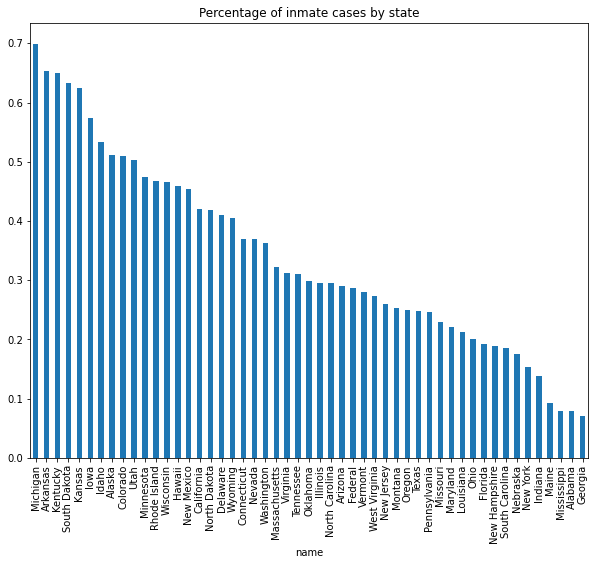

In [1054]:
#Percentage of prisners that caught COVID-19 by state
plt.figure(figsize = (10,8))
plt.title('Percentage of inmate cases by state')
pc_by_state = model_rates['prisoner_cases_pct'].sort_values(ascending = False).plot(kind = 'bar')

<AxesSubplot:title={'center':'Percentage of staff cases by state'}, xlabel='name'>

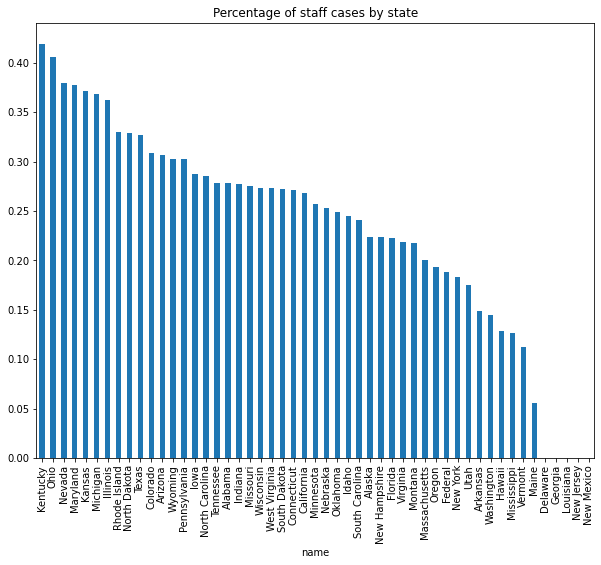

In [1055]:
#Percentage of prison staff that caught COVID-19 by state
plt.figure(figsize = (10,8))
plt.title('Percentage of staff cases by state')
model_rates['staff_cases_pct'].sort_values(ascending = False).plot(kind = 'bar')

<AxesSubplot:xlabel='name'>

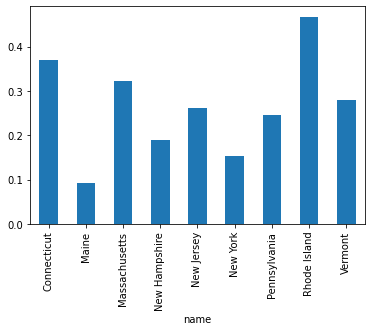

In [1174]:
#Plotting percent of prisoner cases for the NorthEast
model_rates.loc[model_rates['region']== 1]['prisoner_cases_pct'].plot(kind ='bar')

<AxesSubplot:xlabel='name'>

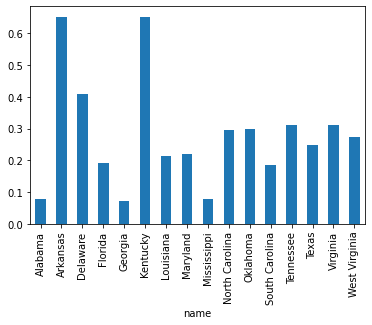

In [1173]:
#Plotting percent of prisoner cases for the SOUTH
model_rates.loc[model_rates['region']== 2]['prisoner_cases_pct'].plot(kind ='bar')

<AxesSubplot:xlabel='name'>

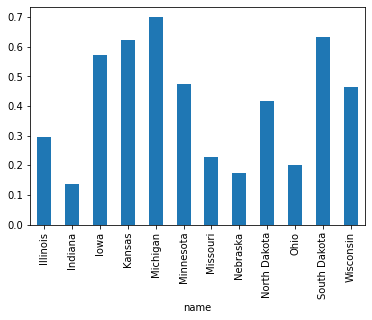

In [1175]:
#Plotting percent of prisoner cases for the Midwest
model_rates.loc[model_rates['region']== 3]['prisoner_cases_pct'].plot(kind ='bar')

<AxesSubplot:xlabel='name'>

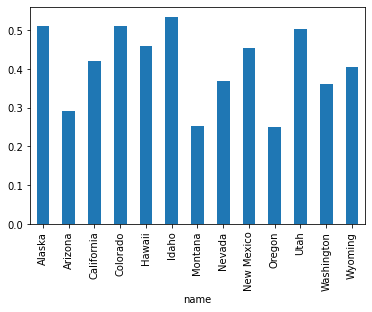

In [1176]:
#Plotting percent of prisoner cases for the West
model_rates.loc[model_rates['region']== 4]['prisoner_cases_pct'].plot(kind ='bar')

The bar plots of percentage of covid cases among prisoners and the percentage of covid cases among incarceration facility staff show no obvious trends. Different states have higher and lower percentages and there is no apparent separation of state percentages based on region.

---
## Inmate_pops dataset
---


In [1056]:
# create a list of state abbrevitations
states = inmate_pops['abbreviation'].unique()
states

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'US', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [1057]:
inmate_pops.head()

,name,abbreviation,month,as_of_date,pop
0,Alabama,AL,march,03/31/2020,21114
1,Alabama,AL,april,04/30/2020,20655
2,Alabama,AL,june,06/30/2020,19752
3,Alabama,AL,july,07/31/2020,19342
4,Alabama,AL,aug,08/31/2020,18901


In [1058]:
#Dropping the 'as_of_date' and 'month' columns as well as setting the index to the 'name' column
model_inmate_pops = inmate_pops.drop(['as_of_date','month'], axis = 1).set_index('name')
model_inmate_pops.head()

,abbreviation,pop
name,,
Alabama,AL,21114
Alabama,AL,20655
Alabama,AL,19752
Alabama,AL,19342
Alabama,AL,18901


In [1059]:
staff_pops.head()

,name,abbreviation,month,as_of_date,pop
0,Alabama,AL,march,03/31/2020,3686.0
1,Alabama,AL,july,06/30/2020,3792.0
2,Alaska,AK,march,03/31/2020,1456.0
3,Alaska,AK,july,07/31/2020,1481.0
4,Arizona,AZ,july,08/01/2020,9095.0


In [1060]:
model_staff_pops = staff_pops.drop(['as_of_date','month'], axis = 1).set_index('name')
model_staff_pops.head()

,abbreviation,pop
name,,
Alabama,AL,3686.0
Alabama,AL,3792.0
Alaska,AK,1456.0
Alaska,AK,1481.0
Arizona,AZ,9095.0


In [1061]:
#creating a list of only the maximum inmate population per state
max_inmates = []
for i in states:
 max_inmates.append(inmate_pops.loc[inmate_pops['abbreviation'] == i]['pop'].max())

In [1062]:
#creating a list of only the maximum staff population per state
max_staff = []
for i in states:
    max_staff.append(staff_pops.loc[staff_pops['abbreviation'] == i]['pop'].max())

In [1063]:
e = cases['name'].unique()
f = max_inmates
g = max_staff
pop_merge = pd.DataFrame(np.array(list(zip(e,f,g))), columns = ['name','max_inmate_pop', 'max_staff_pop'])#.set_index('name')
pop_merge.head()

,name,max_inmate_pop,max_staff_pop
0,Alabama,21114,3792.0
1,Alaska,4776,1481.0
2,Arizona,42360,9095.0
3,Arkansas,17502,5460.0
4,California,117639,63471.0


In [1064]:
#Adding a column for maximum inmate population and a column for maximum staff population
#model_rates = model_rates.merge(pop_merge, right_on = 'name' , left_on = 'name')

In [1166]:
model_rates.head()

,cumulative_prisoner_cases,prisoner_cases_pct,cumulative_prisoner_deaths,prisoner_deaths_pct,cumulative_staff_cases,staff_cases_pct,cumulative_staff_deaths,staff_deaths_pct,region,max_inmate_pop,max_staff_pop,prisoner_deaths_per_case,staff_deaths_per_case,clusters,color
name,,,,,,,,,,,,,,,
Alabama,1661,0.078668,66,0.003126,1056,0.278481,3,0.000791,2.0,21114.0,3792.0,0.039735,0.002841,0,red
Alaska,2440,0.510888,5,0.001047,332,0.224173,0,0.000000,4.0,4776.0,1481.0,0.002049,0.000000,0,red
Arizona,12328,0.291029,65,0.001534,2787,0.306432,1,0.000110,4.0,42360.0,9095.0,0.005273,0.000359,0,red
Arkansas,11425,0.652783,52,0.002971,813,0.148901,4,0.000733,2.0,17502.0,5460.0,0.004551,0.004920,0,red
California,49395,0.419886,227,0.001930,17002,0.267870,28,0.000441,4.0,117639.0,63471.0,0.004596,0.001647,1,green


<AxesSubplot:title={'center':'Maximum Inmate Population by State'}, xlabel='name'>

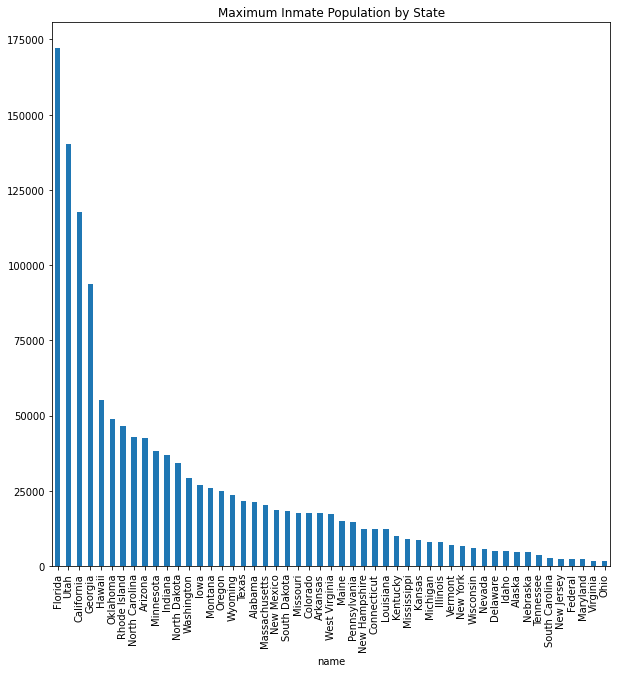

In [1167]:
plt.figure(figsize = (10,10))
plt.title('Maximum Inmate Population by State')
model_rates['max_inmate_pop'].sort_values(ascending = False).plot(kind = 'bar')

<AxesSubplot:title={'center':'Maximum Staff Population by State'}, xlabel='name'>

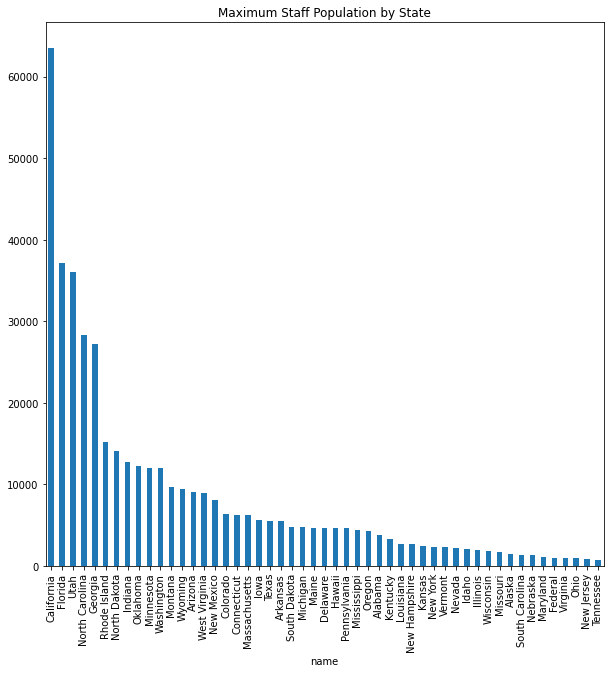

In [1168]:
plt.figure(figsize = (10,10))
plt.title('Maximum Staff Population by State')
model_rates['max_staff_pop'].sort_values(ascending = False).plot(kind = 'bar')

Similar to the plot of case percentages, the bar plots of maximum population of prison inmates per state also shows no obvious trends and interestingly it does not correspond to the percentages. This means that the data shows that prisons with higher populations did not necesarily have higher rates of covid cases.

In [1065]:
#Dropping the 'abbreviation' column
model_rates = model_rates.drop('abbreviation', axis = 1)

In [1066]:
#Setting the index of the dataset to 'name' and checking for datatypes to prepare for model
model_rates.set_index('name')
model_rates.dtypes

name                           object
latest_week                    object
cumulative_prisoner_cases       int64
prisoner_cases_pct            float64
cumulative_prisoner_deaths      int64
prisoner_deaths_pct           float64
cumulative_staff_cases          int64
staff_cases_pct               float64
cumulative_staff_deaths         int64
staff_deaths_pct              float64
region                         object
max_inmate_pop                 object
max_staff_pop                  object
dtype: object

In [1067]:
#Changing object datatypes to numerical datatypes
model_rates[['region','max_inmate_pop','max_staff_pop']]= model_rates[['region','max_inmate_pop','max_staff_pop']].astype(float)

In [1068]:
#Average percentage and number of prisoners who died due to COVID - 19
print(model_rates['prisoner_deaths_pct'].mean()*100)
print(model_rates['cumulative_prisoner_deaths'].mean())

0.1969518171635331
53.21568627450981


In [1069]:
#Average percentage and number of prison staff who died due to COVID - 19
print(model_rates['staff_deaths_pct'].mean()*100)
print(model_rates['cumulative_staff_deaths'].mean())

0.04524004399749396
4.098039215686274


On average .19% of prisoners died, which is approximately 56 prisoners per state. And on average .04% of staff died, which is approximately 4 members of the staff per state. 

count    51.000000
mean      0.341398
std       0.163173
min       0.070339
25%       0.224882
50%       0.298726
75%       0.462435
max       0.699235
Name: prisoner_cases_pct, dtype: float64
count    46.000000
mean      0.259646
std       0.080770
min       0.055752
25%       0.218195
50%       0.271914
75%       0.305463
max       0.419428
Name: staff_cases_pct, dtype: float64


<AxesSubplot:>

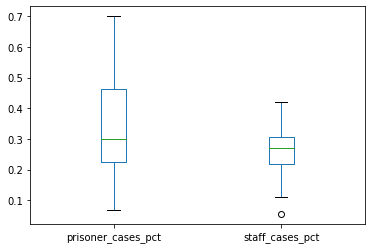

In [1070]:
print(model_rates['prisoner_cases_pct'].describe())
print(model_rates['staff_cases_pct'].describe())
model_rates[['prisoner_cases_pct', 'staff_cases_pct']].plot(kind = 'box')

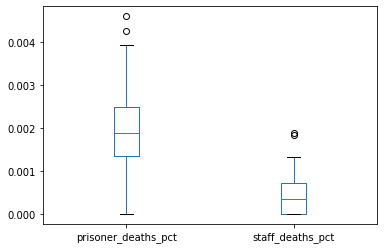

In [1071]:
model_rates[['prisoner_deaths_pct','staff_deaths_pct']].plot(kind = 'box');

These boxplots show the spread of percent of cases and deaths among prisoners and staff per state. Both plots show a very similar trend: Inmates both contracted and died from covid at much higer rates than staff members. 

In [1072]:
#State with the highest percentage of prisoner deaths
model_rates.loc[model_rates['prisoner_deaths_pct'] == model_rates['prisoner_deaths_pct'].max()]

,name,latest_week,cumulative_prisoner_cases,prisoner_cases_pct,cumulative_prisoner_deaths,prisoner_deaths_pct,cumulative_staff_cases,staff_cases_pct,cumulative_staff_deaths,staff_deaths_pct,region,max_inmate_pop,max_staff_pop
28,Nevada,06/22/2021,4576,0.369509,57,0.004603,1006,0.379909,3,0.001133,4.0,5621.0,2199.0


In [1073]:
#state with the lowest percentage of prisoner deaths
model_rates.loc[model_rates['prisoner_deaths_pct'] == model_rates['prisoner_deaths_pct'].min() ]

,name,latest_week,cumulative_prisoner_cases,prisoner_cases_pct,cumulative_prisoner_deaths,prisoner_deaths_pct,cumulative_staff_cases,staff_cases_pct,cumulative_staff_deaths,staff_deaths_pct,region,max_inmate_pop,max_staff_pop
45,Vermont,06/22/2021,464,0.280193,0,0.0,113,0.112662,0,0.0,1.0,6900.0,2342.0


In [1002]:
#State with the highest percentage of prisoner deaths
model_rates.loc[model_rates['prisoner_cases_pct'] == model_rates['prisoner_cases_pct'].max()]

,cumulative_prisoner_cases,prisoner_cases_pct,cumulative_prisoner_deaths,prisoner_deaths_pct,cumulative_staff_cases,staff_cases_pct,cumulative_staff_deaths,staff_deaths_pct,region,max_inmate_pop,max_staff_pop,clusters,dcluster,prisoner_deaths_per_case,staff_deaths_per_case
name,,,,,,,,,,,,,,,
Michigan,26694,0.699235,141,0.003693,4403,0.368051,6,0.000502,3.0,7969.0,4764.0,0,-1,0.005282,0.001363


In [1074]:
#Creating columns for the rate of death per case
model_rates['prisoner_deaths_per_case'] = model_rates['cumulative_prisoner_deaths']/model_rates['cumulative_prisoner_cases']
model_rates['staff_deaths_per_case'] = model_rates['cumulative_staff_deaths']/model_rates['cumulative_staff_cases']

In [937]:
model_rates.head()

,cumulative_prisoner_cases,prisoner_cases_pct,cumulative_prisoner_deaths,prisoner_deaths_pct,cumulative_staff_cases,staff_cases_pct,cumulative_staff_deaths,staff_deaths_pct,region,max_inmate_pop,max_staff_pop,clusters,dcluster,prisoner_deaths_per_case,staff_deaths_per_case
name,,,,,,,,,,,,,,,
Alabama,1661,0.078668,66,0.003126,1056,0.278481,3,0.000791,2.0,21114.0,3792.0,0,0,0.039735,0.002841
Alaska,2440,0.510888,5,0.001047,332,0.224173,0,0.000000,4.0,4776.0,1481.0,0,1,0.002049,0.000000
Arizona,12328,0.291029,65,0.001534,2787,0.306432,1,0.000110,4.0,42360.0,9095.0,0,1,0.005273,0.000359
Arkansas,11425,0.652783,52,0.002971,813,0.148901,4,0.000733,2.0,17502.0,5460.0,0,-1,0.004551,0.004920
California,49395,0.419886,227,0.001930,17002,0.267870,28,0.000441,4.0,117639.0,63471.0,1,-1,0.004596,0.001647


In [1170]:
print("Staff death rate per case :",model_rates['staff_deaths_per_case'].mean())
print("Inmate death rate per case :",model_rates['prisoner_deaths_per_case'].mean())

Staff death rate per case : 0.0017045603011330826
Inmate death rate per case : 0.007497153055955591


On average prisoners who contrated Covid-19 were 7 times more likely to die from the disease than staff members

In [1077]:
#Checking the null values to prepare for modeling
model_rates.isnull().sum()

name                          0
latest_week                   0
cumulative_prisoner_cases     0
prisoner_cases_pct            0
cumulative_prisoner_deaths    0
prisoner_deaths_pct           0
cumulative_staff_cases        0
staff_cases_pct               5
cumulative_staff_deaths       0
staff_deaths_pct              5
region                        0
max_inmate_pop                0
max_staff_pop                 3
prisoner_deaths_per_case      0
staff_deaths_per_case         0
dtype: int64

In [1080]:
#Imputing for null values
model_rates['staff_cases_pct'] = model_rates['staff_cases_pct'].fillna(model_rates['staff_cases_pct'].median())
model_rates['staff_deaths_pct'] = model_rates['staff_deaths_pct'].fillna(model_rates['staff_deaths_pct'].median())
model_rates['max_staff_pop'] = model_rates['max_staff_pop'].fillna(model_rates['max_staff_pop'].median())

In [1081]:
model_rates.isnull().sum()

name                          0
latest_week                   0
cumulative_prisoner_cases     0
prisoner_cases_pct            0
cumulative_prisoner_deaths    0
prisoner_deaths_pct           0
cumulative_staff_cases        0
staff_cases_pct               0
cumulative_staff_deaths       0
staff_deaths_pct              0
region                        0
max_inmate_pop                0
max_staff_pop                 0
prisoner_deaths_per_case      0
staff_deaths_per_case         0
dtype: int64

Additional columns were added to measure the rate of people who contracted the disease and then died from it. Then any missing values were filled with either the median or the mean of the column.

# Modeling 
---

## Kmeans Clustering

In [1082]:
#Importing clustering package
import sklearn.cluster as cluster

In [1083]:
#Checking the number of columns and rows
model_rates.shape

(51, 15)

In [1084]:
#Verifying datatypes
model_rates.dtypes

name                           object
latest_week                    object
cumulative_prisoner_cases       int64
prisoner_cases_pct            float64
cumulative_prisoner_deaths      int64
prisoner_deaths_pct           float64
cumulative_staff_cases          int64
staff_cases_pct               float64
cumulative_staff_deaths         int64
staff_deaths_pct              float64
region                        float64
max_inmate_pop                float64
max_staff_pop                 float64
prisoner_deaths_per_case      float64
staff_deaths_per_case         float64
dtype: object

In [1085]:
#Preparing the data for the model
model_rates = model_rates.set_index('name').drop('latest_week', axis = 1)

In [1086]:
#Scaling the data
sc = StandardScaler()
X_scaled = sc.fit_transform(model_rates)

In [1087]:
#Initiating and performing the cluster
kmeans = cluster.KMeans(n_clusters = 2, init = 'k-means++')
kmeans = kmeans.fit(X_scaled)

In [1088]:
#Creating a new column that shows the cluster for each state
model_rates['clusters'] = kmeans.labels_

In [1090]:
model_rates.head()

,cumulative_prisoner_cases,prisoner_cases_pct,cumulative_prisoner_deaths,prisoner_deaths_pct,cumulative_staff_cases,staff_cases_pct,cumulative_staff_deaths,staff_deaths_pct,region,max_inmate_pop,max_staff_pop,prisoner_deaths_per_case,staff_deaths_per_case,clusters
name,,,,,,,,,,,,,,
Alabama,1661,0.078668,66,0.003126,1056,0.278481,3,0.000791,2.0,21114.0,3792.0,0.039735,0.002841,0
Alaska,2440,0.510888,5,0.001047,332,0.224173,0,0.000000,4.0,4776.0,1481.0,0.002049,0.000000,0
Arizona,12328,0.291029,65,0.001534,2787,0.306432,1,0.000110,4.0,42360.0,9095.0,0.005273,0.000359,0
Arkansas,11425,0.652783,52,0.002971,813,0.148901,4,0.000733,2.0,17502.0,5460.0,0.004551,0.004920,0
California,49395,0.419886,227,0.001930,17002,0.267870,28,0.000441,4.0,117639.0,63471.0,0.004596,0.001647,1


In [1091]:
#Checking the number of clusters and 
model_rates['clusters'].value_counts()

0    47
1     4
Name: clusters, dtype: int64

In [1095]:
#Determing the best number of clusters 
best_scores = []
for k in range(2, 15):
  cl = KMeans(n_clusters=k)
  cl.fit(X_scaled)
  inertia = cl.inertia_
  sil = silhouette_score(X_scaled, cl.labels_)
  scores.append([k, inertia, sil])

#Creating a dataset of the ressults of the number of clusters test
best_score_df = pd.DataFrame(scores)
best_score_df.columns = ["k", "inertia", "silhouette"]
best_score_df.head()

,k,inertia,silhouette
0,2,387.628263,0.485708
1,3,334.441949,0.160583
2,4,291.258449,0.164330
3,5,256.468653,0.189329
4,6,226.061473,0.170694


In [1096]:
#Veryifying the best performing number of clusters
best_score_df.loc[best_score_df['silhouette'] == best_score_df['silhouette'].max()]

,k,inertia,silhouette
58,2,474.847747,0.490439


<AxesSubplot:xlabel='k'>

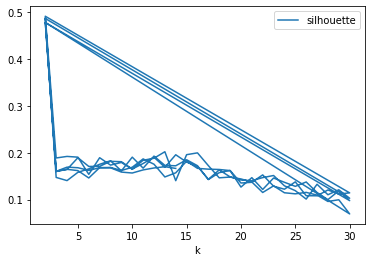

In [1097]:
#plotting how silhouette score over different numbers of clusters
best_score_df.plot(x="k", y="silhouette")

In [1098]:
#Calcultating the Silhouette score
silhouette_score(X_scaled, kmeans.labels_)

0.4771431723641308

In [1128]:
#Getting the centroids
centroids = pd.DataFrame(sc.inverse_transform(kmeans.cluster_centers_))
centroids.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,5257.829787,0.346049,36.914894,0.001973,1539.531915,0.261626,2.553191,0.000433,2.574468,21808.765957,6805.340426,0.007499,0.001684
1,37876.750000,0.286750,244.750000,0.001934,10469.000000,0.251707,22.250000,0.000553,3.250000,78393.750000,26789.750000,0.007480,0.001942


Text(0.5, 1.0, 'Centroids by cluster')

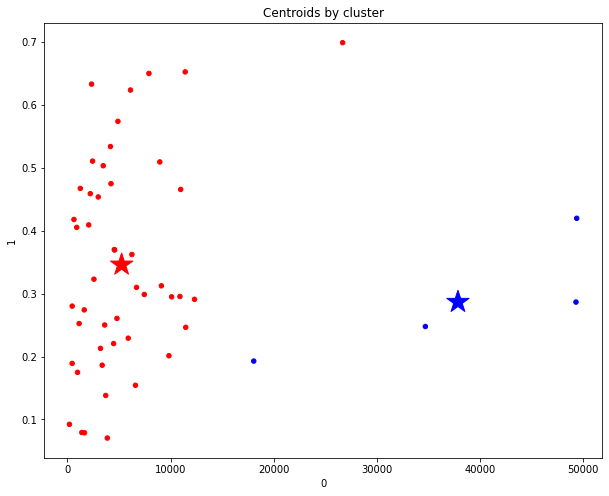

In [1171]:
# Plotting the cluster centroids
colors = ["red", "blue"]
model_rates['color'] = model_rates['clusters'].map(lambda p: colors[p])

ax = model_rates.plot(    
    kind="scatter", 
    x= 0, y= 1,
    figsize=(10,8),
    c = model_rates['color']
)

centroids.plot(
    kind="scatter", 
    x= 0 , y= 1, 
    marker="*", c=["r", "b"], s=550,
    ax=ax
);
plt.title("Centroids by cluster")

In [1099]:
#making masks for each cluster
cluster_0 = model_rates["clusters"] == 0
cluster_1 = model_rates["clusters"] == 1

In [1158]:
#Retrieving the average stats for all states in cluster 0
model_rates[cluster_0].mean()

cumulative_prisoner_cases      5257.829787
prisoner_cases_pct                0.346049
cumulative_prisoner_deaths       36.914894
prisoner_deaths_pct               0.001973
cumulative_staff_cases         1539.531915
staff_cases_pct                   0.261626
cumulative_staff_deaths           2.553191
staff_deaths_pct                  0.000433
region                            2.574468
max_inmate_pop                21808.765957
max_staff_pop                  6805.340426
prisoner_deaths_per_case          0.007499
staff_deaths_per_case             0.001684
clusters                          0.000000
dtype: float64

In [1172]:
#Retrieving the average stats for all states in cluster 1
model_rates[cluster_1].mean()

cumulative_prisoner_cases     37876.750000
prisoner_cases_pct                0.286750
cumulative_prisoner_deaths      244.750000
prisoner_deaths_pct               0.001934
cumulative_staff_cases        10469.000000
staff_cases_pct                   0.251707
cumulative_staff_deaths          22.250000
staff_deaths_pct                  0.000553
region                            3.250000
max_inmate_pop                78393.750000
max_staff_pop                 26789.750000
prisoner_deaths_per_case          0.007480
staff_deaths_per_case             0.001942
clusters                          1.000000
dtype: float64

In [1102]:
#Checking which states are in cluster 1 
model_rates[cluster_1].head(10)

,cumulative_prisoner_cases,prisoner_cases_pct,cumulative_prisoner_deaths,prisoner_deaths_pct,cumulative_staff_cases,staff_cases_pct,cumulative_staff_deaths,staff_deaths_pct,region,max_inmate_pop,max_staff_pop,prisoner_deaths_per_case,staff_deaths_per_case,clusters
name,,,,,,,,,,,,,,
California,49395,0.419886,227,0.001930,17002,0.267870,28,0.000441,4.0,117639.0,63471.0,0.004596,0.001647,1
Federal,49324,0.286621,258,0.001499,7008,0.188758,4,0.000108,5.0,2232.0,1018.0,0.005231,0.000571,1
Florida,18072,0.192739,221,0.002357,6066,0.222859,9,0.000331,2.0,172088.0,37127.0,0.012229,0.001484,1
Texas,34716,0.247752,273,0.001948,11800,0.327341,48,0.001332,2.0,21616.0,5543.0,0.007864,0.004068,1


<AxesSubplot:>

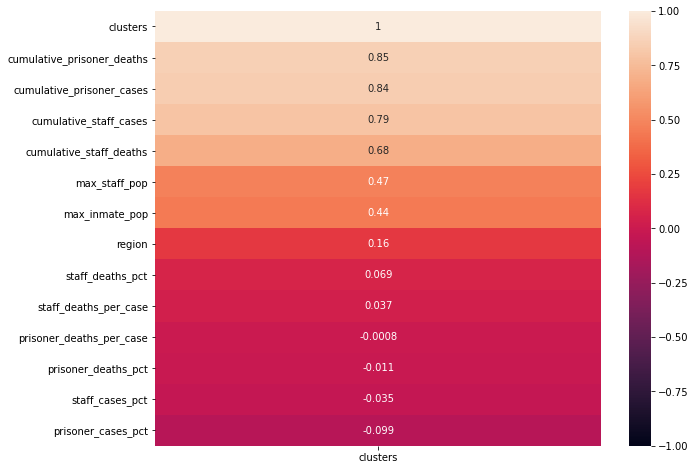

In [1147]:
#Checking which columns contributed the most to which cluster a state was assigned to
plt.figure(figsize = (10,8))
sns.heatmap(model_rates.corr()[['clusters']].sort_values(by = 'clusters', ascending = False), vmin = -1, vmax = 1, annot = True)

After performing a clustering analysis, the states were grouped into just two different clusters. The optimal number of clusters was verified and after examinig the average values for each cluster it appears that the major defining factor of each cluster was its maximum population size. The four states with the highest populations were grouped into one cluster and all of the rest were grouped into another. When examining other factors it is interesting to note that the cluster of states with lower populations actually on average had higher rates of the spread of the disease at 35% prisoner case percentage as opposed to 28% prisoner case percentage in larger population prisons. 

## DB Scan clusters

In [1178]:
#Initializing and performing the DBscan clustering
db = DBSCAN(eps=2.3, min_samples=4)
db.fit(X_scaled)

DBSCAN(eps=2.3, min_samples=4)

In [1179]:
#Creating a column for the DBscan clusters
model_rates['dcluster'] = db.labels_

In [1180]:
#Checking how many states were assigned to each cluster
model_rates['dcluster'].value_counts()

 0    31
-1    20
Name: dcluster, dtype: int64

In [1181]:
#Calculating the silhouette score of the clusters
silhouette_score(X_scaled, db.labels_)

0.19794416046167082

<AxesSubplot:>

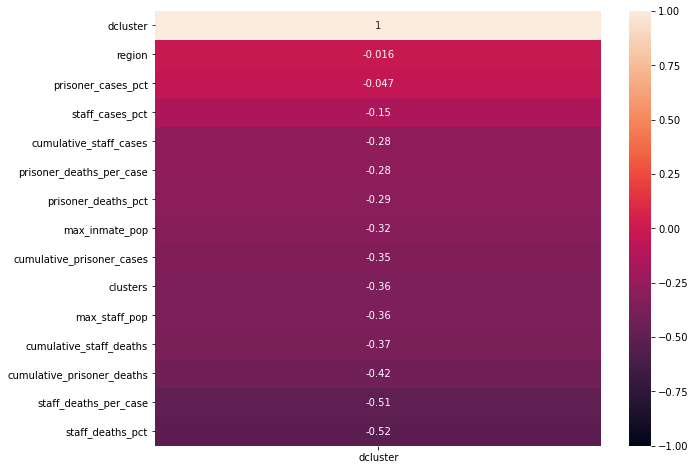

In [1182]:
#Checking which columns contributed the most to which cluster a state was assigned to
plt.figure(figsize = (10,8))
sns.heatmap(model_rates.corr()[['dcluster']].sort_values(by = 'dcluster', ascending = False), vmin = -1, vmax = 1, annot = True)

Performed a DBscan clustering of the data. In this analysis the data was also grouped into only two different clusters, but the silhouette score was very low which signified that the clusters did were not very different from each other and the clustering did not provide much meaningful insight. Because of this I did not further explore the DBscan clusters and focused on the KMeans clusters. It is interesting to note though that the DB clusters relied most on region and percentages than the KMeans which relied mostly cummulative numbers.

# Conclusions and Recommendations

The goal of this project was to examine trends in the rates that inmates and staff members in different state prisons were affected by COVID-19 so that I could draw insights into what could be causing those trends. After data manipulation, feature engineering and analysis I was not able to find any major trends. From what I have done thus far the only thing that can be said is that prisons with higher populations had higher numbers of cases. Regardless of region or even prison population, by this analysis percentage wise there were no major differences that set certain states apart from others. There was no way to group good performing or bad performing states so I after all of this I think I chose the wrong kind of testing methods. 

In order to draw better insight I would recommend breaking the analysis down by state and possibly grouping based on percentages instead of population or region. This would be a lot more involved but would provide better insights that could be significant and used to determine what factors are protective or detrimental to prisons when protecting their inmates and staff from a pandemic. A few steps that I would recommend are:
Including information of square footage of facilities, including data on age of inmates, including data on housing type, ie how many inmates per cell and hypothesis testing to see if there are differences in the rates of the disease in each state or even in the states with lower rates vs those with higher rates.
